# visión estereoscópica

(geometría de dos vistas)

<img src="../images/demos/stereo.png" width="500px"/>

## teoría

### depth map

<img src="../images/demos/xtion.jpg" width="800px"/>

(kinect, xtion, ...)

[RGBD processing in OpencV](https://docs.opencv.org/3.4/d2/d3a/group__rgbd.html)

- - -

### visión estereoscópica



[stellar parallax](https://en.wikipedia.org/wiki/Stellar_parallax)


[disparity](http://docs.opencv.org/3.1.0/dd/d53/tutorial_py_depthmap.html#gsc.tab=0)

[random dot stereogram](https://en.wikipedia.org/wiki/Random_dot_stereogram)

[autostereogram](https://en.wikipedia.org/wiki/Autostereogram)




### reproyección de puntos y rectas

<img src="../images/demos/repropoint.png" width="300px"/>

<img src="../images/demos/reproline.png" width="300px"/>


### triangulation

<img src="../images/demos/triangulation2.png" width="500px"/>



### Resultado 1:

Si conocemos las matrices de cámara podemos triangular puntos correspondientes.
Importante: **"sobra" un grado de libertad**.


### geometría epipolar

<img src="../images/demos/epipolar.png" width="500px"/>


### restricción epipolar

<img src="../images/demos/epipolar2.png" width="500px"/>


### epipolar transfer

<img src="../images/demos/transfer.png" width="500px"/>



### Resultado 2:

Las cámaras nos dan la geometría epipolar, que nos ayuda
a conseguir puntos correspondientes correctos.



### Resultado 3:

Unos pocos puntos correspondientes permiten obtener directamente la geometría epipolar.



### Resultado 4:

De la geometría epipolar (matriz $F$) podemos extraer las cámaras.


### teorema fundamental de la visión geométrica

- puntos correspondientes $\rightarrow$ matriz $F$ $\rightarrow$ cámaras

- puntos correspondientes $+$ cámaras $\rightarrow$ puntos 3D

(salvo escala, si conocemos $K$)

por tanto:

- puntos correspondientes $\simeq$ puntos 3D 

es decir:

- puntos correspondientes $\rightarrow$ *structure and motion*


[The Fundamental Matrix Song](http://danielwedge.com/fmatrix)

demo ev

[geometría epipolar en OpenCV](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_epipolar_geometry/py_epipolar_geometry.html)

### 3 vistas

<img src="../images/demos/trifocal.png" width="500px"/>


### n vistas

<img src="../images/demos/sfm.png" width="500px"/>

[VisualSFM](http://ccwu.me/vsfm/)

[Pix4d](https://www.sensefly.com/drones/photogrammetry-software.html)


## resumen de la teoría

Deseamos obtener la estructura 3D de una escena a partir de dos (o más) imágenes.

Si conocemos las matrices de cámara podemos hacer triangulación de puntos correspondientes.

La triangulación es muy simple si las cámaras están alineadas.

La triangulación con cámaras generales también es sencilla, resolviendo un sistema de ecuaciones.

En muchos casos desconocemos (casi) todo: las matrices de cámara y la escena. (Aunque viene muy bien tener las matrices de calibración).

El resultado fundamental de la geometría de dos vistas: puntos correspondientes tienen que estar en las líneas epipolares.

Esta "geometría epipolar" surge del hecho sencillo de que los rayos ópticos de puntos correspondientes y la línea base forman un triángulo en el espacio.

Esa condición nos permite descartar correspondencias erróneas.

Gracias a que trabajamos con coordenadas homogéneas, las líneas epipolares se consiguen mediante una transformación lineal cuya matriz de coeficientes es la "matriz Fundamental" $F$ del par estéreo. $F$ se puede construir fácilmente a partir de las cámaras.

Los puntos correspondientes cumplen $x' \cdot F x = 0$.

A partir de puntos correspondientes podemos encontrar F (p. ej. resolviendo un sistema de ecuaciones homogéno (aunque es conveniente "arreglar" un par de detalles)).

A partir de $F$ podemos encontrar cámaras compatibles, que nos permiten triangular los puntos correspondientes, resolviendo el problema.

Si desconocemos las matrices de calibración $K$ la reconstrucción tiene ambigüedad proyectiva. Existen deformaciones del espacio que, con cámaras deformadas "inversamente", producen la misma geometría epipolar $F$.

Si conocemos las $K$, entonces podemos mejorar la restricción epipolar $F$ sobre pixels crudos y establecerla sobre puntos normalizados (imagen óptica ideal), por medio de la "matriz Esencial": $x_n' \cdot E x_n = 0$.

$$ x'^T F x = 0$$

Los pixels crudos se relacionan con los normalizados mediante $x = K x_n$, por tanto:

$$ x_n'^T \, \underbrace{K^T F K}_E \, x_n = 0 $$

La matriz esencial depende solo de la dirección del desplazamiento y la orientación relativa entre las dos cámaras. ($E = t_\times R $).

Estos dos ingredientes se pueden extraer fácilmente de la matriz esencial estimada, lo que permite encontrar "cámaras reales", con la única ambiguedad de la longitud de la línea base. Por tanto la reconstrucción solo tendrá ambigüedad de escala.

Hay 4 soluciones posibles, de las cuales solo una tiene sentido (la que reconstruye (triangula) los puntos por delante).

En conclusión, $K$ + puntos correspondientes $\rightarrow$ cámaras (posición, movimiento) + estructura 3D de la escena. Es lo que se conoce como el problema *SfM* (structure from motion) o *SLAM* simultaneous localization and mapping.

Si desconocemos $K$ no todo está perdido: podemos autocalibrar.

Un método simple de autocalibración consiste en buscar el parámetro esencial de calibración $f$ (relacionado con el campo de visión), que da lugar a una matriz E geométricamente válida (que contenga una rotación).

## bibliotecas

In [1]:
%matplotlib inline

import numpy             as np
import cv2               as cv
import numpy.linalg      as la
import matplotlib.pyplot as plt

from matplotlib.pyplot   import imshow, subplot, title, plot
from ipywidgets          import interactive

from umucv.htrans import homog, inhomog, kgen, jc, col
from umucv.util   import shline

def fig(w,h):
    plt.figure(figsize=(w,h))

def readrgb(file):
    return cv.cvtColor( cv.imread('../images/'+file), cv.COLOR_BGR2RGB) 

def rgb2gray(x):
    return cv.cvtColor(x,cv.COLOR_RGB2GRAY)

def readgray(file):
    return cv.imread('../images/'+file, 0) 

def imshowg(x):
    imshow(x, 'gray')

## dense depth map

Supongamos que tenemos un par estéreo rectificado: los puntos correspondientes están en la misma fila de pixels. (Obtenido por software, o con una cámara estéreo precalibrada).

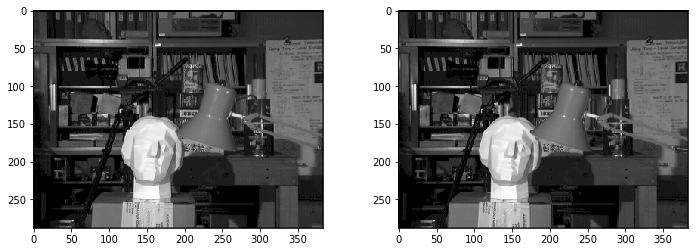

In [2]:
x1 = readgray('tsukuba-l.png')
x2 = readgray('tsukuba-r.png')

fig(12,4)
subplot(1,2,1); imshowg(x1)
subplot(1,2,2); imshowg(x2)

Superponiendo las dos se aprecia la disparidad.

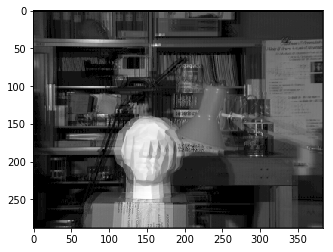

In [3]:
imshowg(x1//2+x2//2)

Usaremos un *stereo matcher* de opencv para determinar la disparidad de cada pixel.

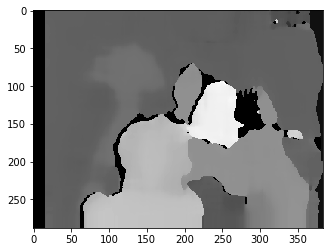

In [4]:
sgbm = cv.StereoSGBM_create(0,16,30)
disparity = sgbm.compute(x1,x2)
imshowg(disparity)

En principio podríamos convertir estas disparidades en profundidad (distancias a la cámara).

## geometría epipolar 

(geometría de dos vistas o geometría estéreo)

Un problema más interesante es la reconstrucción 3D cuando no se conocen las cámaras. En un primer ejercicio vamos a utilizar correspondencias marcadas a mano para verificar los algoritmos.

(Cuando la línea base es pequeña se pueden usar detectores de keypoints para encontrar correspondencias automáticamente, como veremos en el ejercicio siguiente. Este experimento es de línea base ancha, donde sería necesario usar "tracking".)

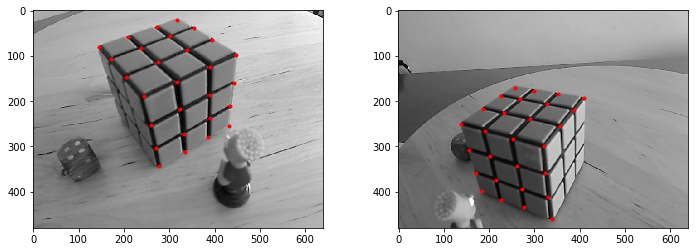

In [5]:
v1 = np.array(
      [[ 278.,  343.],
       [ 335.,  312.],
       [ 386.,  279.],
       [ 433.,  254.],
       [ 270.,  304.],
       [ 332.,  272.],
       [ 389.,  238.],
       [ 434.,  210.],
       [ 260.,  253.],
       [ 324.,  218.],
       [ 389.,  186.],
       [ 442.,  160.],
       [ 244.,  189.],
       [ 317.,  158.],
       [ 390.,  125.],
       [ 447.,   97.],
       [ 204.,  147.],
       [ 276.,  114.],
       [ 340.,   87.],
       [ 395.,   64.],
       [ 172.,  107.],
       [ 238.,   83.],
       [ 302.,   55.],
       [ 355.,   39.],
       [ 146.,   81.],
       [ 210.,   58.],
       [ 273.,   37.],
       [ 318.,   21.]])

v2 = np.array(
      [[ 184.,  399.],
       [ 226.,  418.],
       [ 277.,  434.],
       [ 338.,  460.],
       [ 171.,  358.],
       [ 216.,  374.],
       [ 273.,  394.],
       [ 331.,  412.],
       [ 155.,  307.],
       [ 203.,  321.],
       [ 262.,  342.],
       [ 324.,  358.],
       [ 138.,  251.],
       [ 191.,  265.],
       [ 252.,  284.],
       [ 321.,  299.],
       [ 186.,  218.],
       [ 233.,  227.],
       [ 291.,  240.],
       [ 357.,  255.],
       [ 226.,  188.],
       [ 269.,  196.],
       [ 327.,  206.],
       [ 387.,  220.],
       [ 257.,  170.],
       [ 299.,  177.],
       [ 352.,  185.],
       [ 409.,  194.]])

rgb1 = readrgb('cube3.png')
rgb2 = readrgb('cube4.png')

x1 = rgb2gray(rgb1)
x2 = rgb2gray(rgb2)

fig(12,4)
subplot(1,2,1)
imshowg(x1); ax = plt.axis()
plot(v1[:,0],v1[:,1],'r.'); plt.axis(ax)
subplot(1,2,2)
imshowg(x2)
plot(v2[:,0],v2[:,1],'r.'); plt.axis(ax);

Cuando no hay outliers la matriz $F$ se puede obtener resolviendo un sencillo sistema de ecuaciones. En la práctica es mejor usar la siguiente función de OpenCV que admite correspondencias incorrectas (outliers). La opción `cv.FM_LMEDS` es una alternativa a RANSAC que consigue un resultado parecido.

In [6]:
F,_ = cv.findFundamentalMat(v1,v2,cv.FM_LMEDS)
F

array([[  1.19789663e-06,   6.12855256e-06,   8.51137650e-04],
       [  1.04276245e-05,   2.57755811e-06,  -1.37042447e-02],
       [  1.02107838e-03,   5.88401371e-03,   1.00000000e+00]])

Comprobemos que funciona:

In [7]:
[ x2 @ F @ x1 for x1,x2 in zip(homog(v1),homog(v2)) ]

[-0.051837945445248224,
 -0.038979293405927429,
 -0.015402972955562255,
 -5.6843418860808015e-14,
 -0.03379516631283952,
 0.0008633756838634099,
 -0.0042043851678297273,
 -5.6843418860808015e-14,
 -3.1086244689504383e-14,
 0.0021508341764109318,
 -0.00024978149889598456,
 0.049328513422774556,
 -2.708944180085382e-14,
 0.025669930373434013,
 0.013449176247676942,
 0.033964949074825945,
 0.0033938903417631838,
 -0.00011874031539349517,
 -0.0038717892251498576,
 -0.0094886205563153858,
 0.0049771822500848106,
 0.016197341504458729,
 -0.0063197525869047588,
 -3.9968028886505635e-14,
 -0.018464490469187966,
 -0.019908589885858419,
 -2.7977620220553945e-14,
 -3.5305092183079978e-14]

No son ceros perfectos, pero el residuo es razonablemente pequeño, puede no estar mal del todo.

La matriz fundamental nos da las rectas epipolares de cualquier punto (la recta donde debe estar ese punto en la otra imagen).

In [8]:
pt1 = homog(v1[10])

In [9]:
pt1

lepi = F @ pt1

lepi

array([  2.45703022e-03,  -9.16847292e-03,   2.49162604e+00])

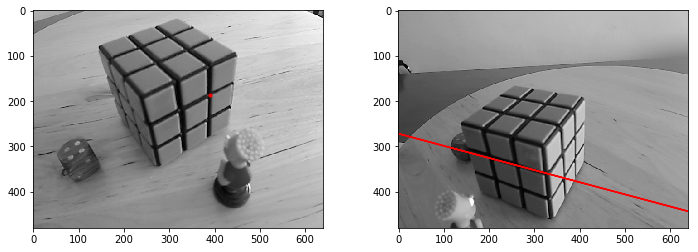

In [10]:
fig(12,4)
subplot(1,2,1)
imshowg(x1); ax = plt.axis()
plot(v1[10,0],v1[10,1],'.',color='red'); plt.axis(ax)
subplot(1,2,2)
imshowg(x2)
shline(lepi)
plt.axis(ax);

$F^T$ hace el mismo trabajo con la imagen derecha.

In [11]:
pt2 = (160,410,1)  # p.ej., en la nariz de Bart

In [12]:
lepi = F.T @ pt2

lepi

array([ 0.00548807,  0.00792138, -4.48255829])

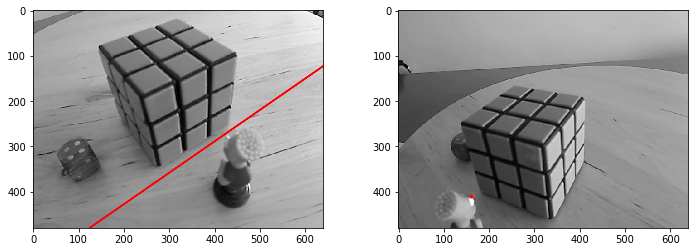

In [13]:
fig(12,4)
subplot(1,2,1)
imshowg(x1);
ax = plt.axis()
shline(lepi)
plt.axis(ax)
subplot(1,2,2)
imshowg(x2)
plot(pt2[0],pt2[1],'.',color='red'); plt.axis(ax);

Para extraer las cámaras necesitamos la matriz de calibración. (Aunque veremos que se puede *autocalibrar*!)

In [14]:
# supongamos que es conocida (aproximadamente lo es)

K = kgen((640,480),1.6)

K

array([[ 512.,    0.,  320.],
       [   0.,  512.,  240.],
       [   0.,    0.,    1.]])

La matriz "Esencial" es la matriz fundamental para coordenadas "calibradas" (F funciona con pixels).

E: cámara calibrada

F: cámara sin calibrar

In [15]:
E = K.T @ F @ K

print(E)

[[ 0.31402141  1.60656328  1.3851224 ]
 [ 2.7335392   0.67569139 -4.99138093]
 [ 2.00040201  4.33344741  1.26490006]]


Será "buena" si los dos primeros valores singulares son iguales (lo que indica que $E$ "codifica" correctamente la  rotación relativa entre las cámaras).

In [16]:
print(la.svd(E)[1])

[  5.80759555e+00   5.30029045e+00   5.56500708e-10]


A partir de la matriz Esencial obtenemos un par de cámaras consistentes con las imágenes observadas. Pero hay 4 posibilidades.

In [17]:
RE1,RE2,t = cv.decomposeEssentialMat(E)

M0 = K @ jc(np.eye(3),col(0,0,0))   # cámara en el origen

# 4 posibilidades para la otra cámara
M1_1 = K @ jc(RE1,t)
M1_2 = K @ jc(RE2,t)
M1_3 = K @ jc(RE1,-t)
M1_4 = K @ jc(RE2,-t)

print(M0)

print(M1_1)

[[ 512.    0.  320.    0.]
 [   0.  512.  240.    0.]
 [   0.    0.    1.    0.]]
[[  5.34287709e+02  -6.07845263e+01  -2.74564903e+02   3.52550487e+02]
 [ -9.07252300e+01  -4.24591946e+02  -3.62263180e+02  -4.74699438e+00]
 [  1.29434413e-01   2.30039070e-01  -9.64535515e-01  -3.65122966e-01]]


In [18]:
from mpl_toolkits.mplot3d import Axes3D
from umucv.util import cameraOutline

def plot3(ax,c,color):
    ax.plot(c[:,0],c[:,1],c[:,2],color)

Probando las 4 posibilidades vemos que el par M0-M1_4 es el que triangula los puntos delante de las cámaras.

In [19]:
p3d = cv.triangulatePoints(M0,M1_4,v1.T,v2.T)
p3d = inhomog(p3d.T)

In [20]:
def fun(a=90):
    fig = plt.figure(figsize=(6,6))
    ax = fig.gca(projection='3d')
    ax.axis('equal')
    plot3(ax,cameraOutline(M0),'blue');
    plot3(ax,cameraOutline(M1_4),'red');
    plot3(ax,p3d,'.g')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=30., azim=a)

interactive(fun, a = (-180,180,10))

interactive(children=(IntSlider(value=90, description='a', max=180, min=-180, step=10), Output()), _dom_classes=('widget-interact',))

### autocalibración

Si desconocemos la matriz de calibración K podemos intentar buscar una que dé lugar a una matriz E "razonable".

In [21]:
# si el parámetro de calibración f es correcto los dos valores singulares de E = KT F K serán iguales
def quality(f):
    K = kgen((640,480),f)
    E = K.T @ F @ K
    s1,s2,_ = la.svd(E)[1]
    return (s1-s2)/s1

In [22]:
quality(1.2)

0.12513627752966452

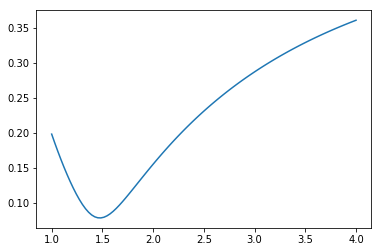

In [23]:
fc = np.linspace(1,4,100)
plot(fc,[quality(f) for f in fc]);

Para que esto funcione razonablemente bien debe haber una rotación relativa apreciable entre las dos imágenes.

## segundo ejemplo

Con "línea base" pequeña podemos obtener F automáticamente con puntos de interés.

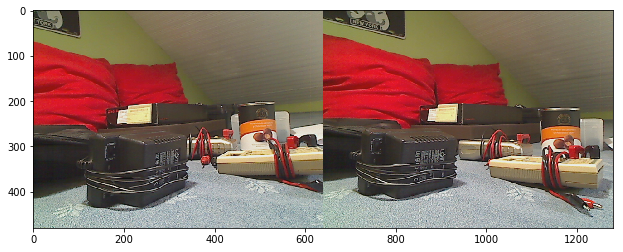

In [24]:
rgb1 = readrgb('left.png')
rgb2 = readrgb('right.png')

x1 = rgb2gray(rgb1)
x2 = rgb2gray(rgb2)

fig(12,4)
imshowg(np.hstack([rgb1,rgb2]));

In [25]:
sift = cv.xfeatures2d.SIFT_create()
(k1, d1) = sift.detectAndCompute(x1, None)
(k2, d2) = sift.detectAndCompute(x2, None)
print(len(k1),len(k2))

1134 1238


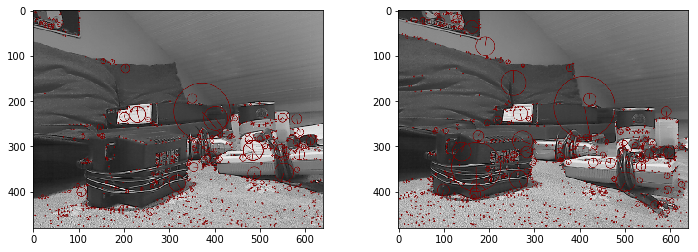

In [26]:
fig(12,4)
subplot(1,2,1)
imshow( cv.drawKeypoints(image=x1,
                         outImage=None,
                         keypoints=k1,
                         flags=4, color = (128,0,0)) );
subplot(1,2,2)
imshow( cv.drawKeypoints(image=x2,
                         outImage=None,
                         keypoints=k2,
                         flags=4, color = (128,0,0)) );

In [27]:
bf = cv.BFMatcher()

matches = bf.knnMatch(d2,d1,k=2)

len(matches)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append(m)

print(len(good))

144


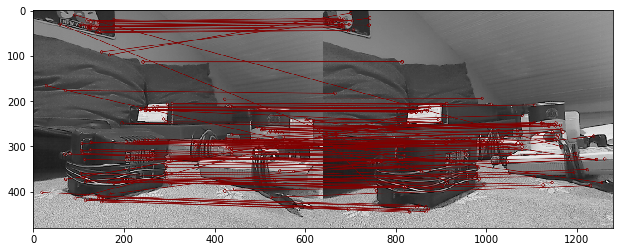

In [28]:
img3 = cv.drawMatches(x2,k2,
                      x1,k1,
                      good,
                      flags=2,outImg=None,
                      matchColor=(128,0,0))
fig(12,4)
plt.imshow(img3);

Como siempre ocurre en estos casos algunas correspondencias son erróneas pero se pueden eliminar si no cumplen la restricción epipolar.

In [29]:
# ponemos los puntos en el formato admitido por cv.findFundamentalMat
p1r = np.array([ k1[m.trainIdx].pt for m in good ]).astype(np.float32).reshape(-1,2)
p2r = np.array([ k2[m.queryIdx].pt for m in good ]).astype(np.float32).reshape(-1,2)

# usamos método robusto frente a correspondencias erróneas ("outliers")
F, mask = cv.findFundamentalMat(p1r,p2r,cv.FM_LMEDS)

F

array([[  1.95713947e-06,   3.25296516e-05,  -8.58608112e-03],
       [  1.56116720e-05,  -2.14739700e-05,  -1.42732638e-01],
       [  3.95699911e-03,   1.35246700e-01,   1.00000000e+00]])

Seleccionamos las correspondencias "buenas".

In [30]:
mask = mask.ravel() > 0  # viene en formato raro, lo paso a array de bool

# inliers
p1 = p1r[mask]
p2 = p2r[mask]

ok = [ x for x,ok in zip(good,mask) if ok]

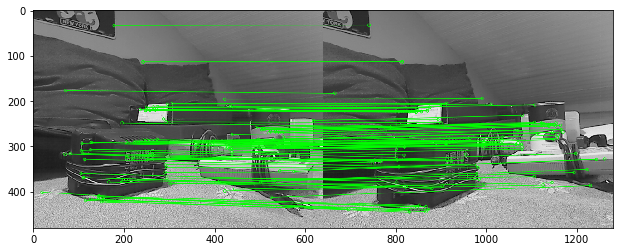

In [31]:
fig(12,4)
img4 = cv.drawMatches(x2,k2,x1,k1,ok,flags=2,outImg=None,matchColor=(0,255,0))
plt.imshow(img4);

Ahora podríamos continuar como en el ejercicio anterior: obtener matriz esencial, cámaras candidatas y triangulación.

Pero mejor vamos a intentar obtener un mapa de disparidad denso, rectificando antes las imágenes. Esto no es fácil... hay un método calibrado, y otro no calibrado. Probaremos hoy este último.

In [32]:
_,H1,H2 = cv.stereoRectifyUncalibrated(p1,p2,F,(640,480))

In [33]:
x1r = cv.warpPerspective(rgb1,H1,(640,480))
x2r = cv.warpPerspective(rgb2,H2,(640,480))

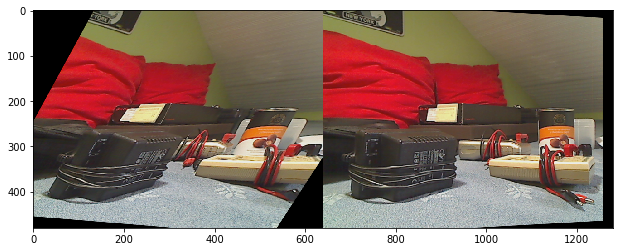

In [34]:
fig(12,4)
imshowg(np.hstack([x1r,x2r]))

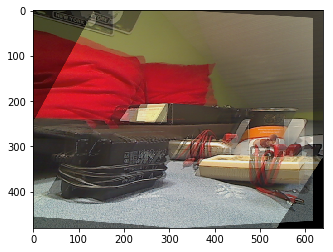

In [35]:
xm=(x1r//2+x2r//2)
imshowg(xm)

El resultado parece correcto: en todos los casos los puntos correspondientes están en la misma fila y relativamente cerca, lo que facilita el cálculo de disparidad densa.

Continuará...